<a href="https://colab.research.google.com/github/Ashish-Sinha07/Twitter-Sentiment-Analysis/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/Dataset/Tweets.csv')

In [ ]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df.shape

(14640, 15)

In [ ]:
# We will fit the model of text vs sentiment
x = df['text']
y= df['airline_sentiment']

In [ ]:
x

,text
0,@VirginAmerica What @dhepburn said.
1,@VirginAmerica plus you've added commercials t...
2,@VirginAmerica I didn't today... Must mean I n...
3,@VirginAmerica it's really aggressive to blast...
4,@VirginAmerica and it's a really big bad thing...
...,...
14635,@AmericanAir thank you we got on a different f...
14636,@AmericanAir leaving over 20 minutes Late Flig...
14637,@AmericanAir Please bring American Airlines to...
14638,"@AmericanAir you have my money, you change my ..."


In [ ]:
y

,airline_sentiment
0,neutral
1,positive
2,neutral
3,negative
4,negative
...,...
14635,positive
14636,negative
14637,neutral
14638,negative


In [ ]:
# Lets encode target variable
le = LabelEncoder()
y = le.fit_transform(y)


In [ ]:
y

array([1, 2, 1, ..., 1, 0, 1])

In [ ]:
# Now lets look at the text data
for i in range(20):
  print(x.iloc[i])

@VirginAmerica What @dhepburn said.
@VirginAmerica plus you've added commercials to the experience... tacky.
@VirginAmerica I didn't today... Must mean I need to take another trip!
@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
@VirginAmerica and it's a really big bad thing about it
@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)
@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP
@virginamerica Well, I didn't…but NOW I DO! :-D
@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.
@VirginAmerica did you know that suicide is the second leading cause of death among teens 10-24
@VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D
@V

## Text Prepocessing

In [ ]:
# Lets clean the text

# Before we proceed lets convert every character to lower case

for i in range(len(x)):
  x.iloc[i] = x.iloc[i].lower()

In [ ]:
#x = x.str.lower()

In [ ]:
x

,text
0,@virginamerica what @dhepburn said.
1,@virginamerica plus you've added commercials t...
2,@virginamerica i didn't today... must mean i n...
3,@virginamerica it's really aggressive to blast...
4,@virginamerica and it's a really big bad thing...
...,...
14635,@americanair thank you we got on a different f...
14636,@americanair leaving over 20 minutes late flig...
14637,@americanair please bring american airlines to...
14638,"@americanair you have my money, you change my ..."


## Noise Removal

In [ ]:
x = x.apply(lambda x: re.sub(r'[^a-z ]','',x))


In [ ]:
x = x.apply(lambda x: re.sub(r'\bhttp\w+\b','',x))

In [ ]:
# Now lets look at the text data
for i in range(20):
  print(x.iloc[i])

virginamerica what dhepburn said
virginamerica plus youve added commercials to the experience tacky
virginamerica i didnt today must mean i need to take another trip
virginamerica its really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse
virginamerica and its a really big bad thing about it
virginamerica seriously would pay  a flight for seats that didnt have this playingits really the only bad thing about flying va
virginamerica yes nearly every time i fly vx this ear worm wont go away 
virginamerica really missed a prime opportunity for men without hats parody there 
virginamerica well i didntbut now i do d
virginamerica it was amazing and arrived an hour early youre too good to me
virginamerica did you know that suicide is the second leading cause of death among teens 
virginamerica i lt pretty graphics so much better than minimal iconography d
virginamerica this is such a great deal already thinking about my nd trip to australia amp i

## Tokenization -->  Stopword removal --> Lemmatizing

In [ ]:
stop_words = stopwords.words('english') # Stopword removal
lemmatizer = WordNetLemmatizer() # Lemmatizing

In [ ]:
def text_preprocessing(text):
  tokens = word_tokenize(text)
  cleaned  = ' '.join([lemmatizer.lemmatize(word,pos='v') for word in tokens if word not in stop_words])
  return cleaned


In [ ]:
x_cleaned  = x.apply(text_preprocessing)

In [ ]:
x_cleaned

,text
0,virginamerica dhepburn say
1,virginamerica plus youve add commercials exper...
2,virginamerica didnt today must mean need take ...
3,virginamerica really aggressive blast obnoxiou...
4,virginamerica really big bad thing
...,...
14635,americanair thank get different flight chicago
14636,americanair leave minutes late flight warnings...
14637,americanair please bring american airlines bla...
14638,americanair money change flight dont answer ph...


## TF-IDF Vectorization

Before we proceed lets do train test split

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x_cleaned,y,train_size=0.75,stratify=y,random_state=2)

In [ ]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(10980,) (10980,) (3660,) (3660,)


In [ ]:
vectorizer = TfidfVectorizer()

In [ ]:
tfidf_train = vectorizer.fit_transform(x_train)
tfidf_test = vectorizer.transform(x_test)

In [ ]:
x_train_v = pd.DataFrame(tfidf_train.toarray(),columns= vectorizer.get_feature_names_out())
x_test_v = pd.DataFrame(tfidf_test.toarray(),columns= vectorizer.get_feature_names_out())

In [ ]:
x_train_v

,aa,aaaand,aaadvantage,aaalwayslate,aaba,aacom,aacustomerservice,aadavantage,aadelay,aadfw,...,zip,zipper,zj,zkatcher,zombie,zone,zoom,zrh,zurich,zurichnew
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
x_test_v

,aa,aaaand,aaadvantage,aaalwayslate,aaba,aacom,aacustomerservice,aadavantage,aadelay,aadfw,...,zip,zipper,zj,zkatcher,zombie,zone,zoom,zrh,zurich,zurichnew
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Lets remove some columns on the basis of % of data the columnn has.

In [ ]:
per_data = ((x_train_v != 0).mean(axis=0)*100).sort_values(ascending=False)

In [ ]:
drop_columns = per_data[per_data<0.1].index

In [ ]:
x_train_v.drop(columns=drop_columns,inplace=True)
x_test_v.drop(columns=drop_columns,inplace=True)

In [ ]:
x_train_v.shape

(10980, 1171)

In [ ]:
x_train_v.head(2)

,aa,able,absolute,absolutely,absurd,accept,acceptable,access,accommodate,account,...,yes,yesterday,yet,yo,youd,youll,youre,youve,yr,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Fit the XGBoost model

In [ ]:
model_xgb = XGBClassifier(n_estimators =100,max_depth=7,class_weights='balanced')


In [ ]:
model_xgb.fit(x_train_v,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weights='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, ...)

In [ ]:
y_pred = model_xgb.predict(x_test_v)

In [ ]:
print('Classification Report',classification_report(y_test,y_pred))

Classification Report               precision    recall  f1-score   support

           0       0.81      0.92      0.86      2294
           1       0.64      0.45      0.53       775
           2       0.74      0.62      0.67       591

    accuracy                           0.77      3660
   macro avg       0.73      0.66      0.69      3660
weighted avg       0.76      0.77      0.76      3660



In [ ]:
y_pred_train = model_xgb.predict(x_train_v)

In [ ]:
print('Classification Report',classification_report(y_train,y_pred_train))

Classification Report               precision    recall  f1-score   support

           0       0.89      0.97      0.92      6884
           1       0.84      0.69      0.75      2324
           2       0.90      0.79      0.84      1772

    accuracy                           0.88     10980
   macro avg       0.87      0.81      0.84     10980
weighted avg       0.88      0.88      0.87     10980



## Neural Network

In [ ]:
# There are two main libraries that are used to perform deep learning
# Tensorflow and pytorch

from tensorflow.keras.models import Sequential # DL Model
from tensorflow.keras.regularizers import l2,l1,l1_l2 # Regularization
from tensorflow.keras.layers import Dense,Dropout # Create dense layer in sequential model


In [ ]:
# Training Data
x_train_v.shape

(10980, 1171)

In [ ]:
pd.Series(y_train).unique() # Multiclass classification Probelm

array([0, 2, 1])

In [ ]:
# Lets design the neural network
model = Sequential()

# first we will add input layer and first hidden layer
model.add(Dense(2000,input_shape=(1171,),activation='relu',kernel_regularizer=l2(0.005)))
model.add(Dropout(0.3))

# lets add second hidden layer
model.add(Dense(1000,activation='relu',kernel_regularizer=l2(0.005)))
model.add(Dropout(0.3))

# lets add third hidden layer
model.add(Dense(500,activation='relu',kernel_regularizer=l2(0.005)))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(3,activation='softmax'))

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 2000)           │     2,344,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1000)           │     2,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │         1,503 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,847,003 (18.49 MB)

 Trainable params: 4,847,003 (18.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Parameters in Hidden layers
print('HL1',1171*2000+2000)
print('HL2',2000*1000+1000)
print('HL3',1000*500+500)
print('Output',500*3+3)

HL1 2344000
HL2 2001000
HL3 500500
Output 1503


In [ ]:
# we have to compile the model
# while compiling we need to define loss
# for regression: loss ='MSE/RMSE'
# for binary classification : loss = 'binary cross entropy'
# for Multiclass: loss = 'sparse_categorical_crossentropy'

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(x_train_v,y_train,epochs=50,batch_size=3000)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 926ms/step - accuracy: 0.5446 - loss: 17.5756
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6275 - loss: 13.6055
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6272 - loss: 10.4165
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6306 - loss: 7.8693
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6275 - loss: 5.9102
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6308 - loss: 4.4137
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6282 - loss: 3.3084
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6247 - loss: 2.5016
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6295 - loss: 1.9223
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6277 - loss: 1.5359
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6279 - loss: 1.2674
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6384 - loss: 1.09

In [ ]:
# We can also visualize how the score have improved and losses reduced.
# plt.plot(model.history.history['loss'])
# plt.show()

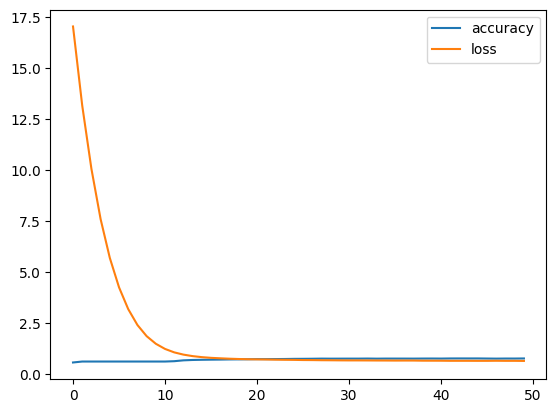

In [ ]:
plt.plot(model.history.history['accuracy'],label='accuracy')
plt.plot(model.history.history['loss'],label='loss')
plt.legend()
plt.show()

In [ ]:
# lets find the score of the model on test data
model.evaluate(x_test_v,y_test)

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7450 - loss: 0.7243


[0.7239945530891418, 0.741256833076477]

In [ ]:
# Lets get the prediction from the model
y_pred_nn = model.predict(x_test_v)

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
y_pred_nn

array([[9.92867112e-01, 6.88772369e-03, 2.45068542e-04],
       [6.15166843e-01, 2.95773655e-01, 8.90594646e-02],
       [8.72433066e-01, 1.10650994e-01, 1.69159435e-02],
       ...,
       [6.12649679e-01, 2.97374338e-01, 8.99760425e-02],
       [9.19217229e-01, 7.21297339e-02, 8.65303632e-03],
       [8.51228774e-01, 1.27555817e-01, 2.12153997e-02]], dtype=float32)

In [ ]:
y_pred_nn_labels = np.argmax(y_pred_nn,axis=1)

In [ ]:
print('Classification report:\n,',classification_report(y_test,y_pred_nn_labels))

Classification report:
,               precision    recall  f1-score   support

           0       0.80      0.92      0.85      2294
           1       0.49      0.35      0.41       775
           2       0.72      0.57      0.64       591

    accuracy                           0.74      3660
   macro avg       0.67      0.61      0.63      3660
weighted avg       0.72      0.74      0.72      3660



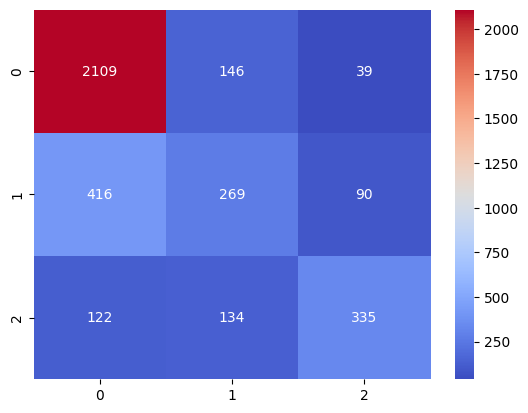

In [ ]:
# Visualize Confusion metrics
sns.heatmap(confusion_matrix(y_test,y_pred_nn_labels),annot=True,fmt='d',cmap='coolwarm')
plt.show()